In [1]:
import torch
import neml2
from pyzag import nonlinear, chunktime
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
import os
from scipy.interpolate import interp1d
import numpy as np

In [2]:
torch.set_default_dtype(torch.double)
if torch.cuda.is_available():
    dev = "cuda:0"
    print("CUDA is available")
    print(f"CUDA version: {torch.version.cuda}")
else:
    dev = "cpu"
    print("CUDA is not available")
device = torch.device(dev)

CUDA is available
CUDA version: 12.8


--- Stress-Temperature Mapping ---
873K_66MPa: 66 MPa, 600C
823K_121MPa: 121 MPa, 550C
773K_363MPa: 363 MPa, 500C
873K_105MPa: 105 MPa, 600C
823K_227MPa: 227 MPa, 550C


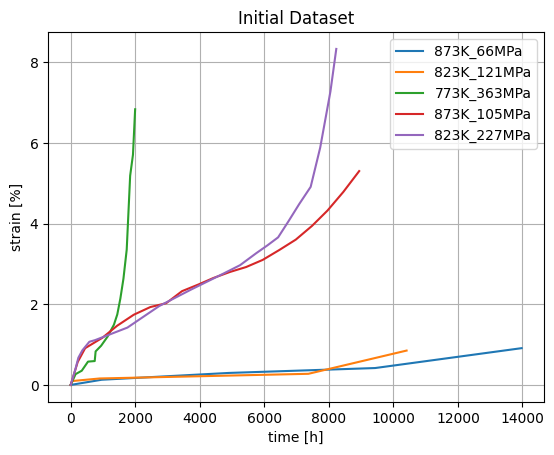

In [3]:
path = '/home/colinmoose/neml2/cmg_projects/creep_data'
data_frames = {}
stress_temp_map = {}
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    df = pd.read_csv(file_path)
    if '66' in filename:
        stress_label = '873K_66MPa'
        stress_temp_map[stress_label] = (66, 873 - 273)
    if '105' in filename:
        stress_label = '873K_105MPa'
        stress_temp_map[stress_label] = (105, 873 - 273)
    if '121' in filename:
        stress_label = '823K_121MPa'
        stress_temp_map[stress_label] = (121, 823 - 273)
    if '227' in filename:
        stress_label = '823K_227MPa'
        stress_temp_map[stress_label] = (227, 823 - 273)
    if '363' in filename:
        stress_label = '773K_363MPa'
        stress_temp_map[stress_label] = (363, 773 - 273)
    new_df = df.rename(columns={'x':f'{stress_label}_time', 'y':f'{stress_label}_strain'})
    data_frames[stress_label] = new_df

strain_data = {}
time_data = {}

for stress_label, df in data_frames.items():
    time_col = f'{stress_label}_time'
    strain_col = f'{stress_label}_strain'
    time = torch.tensor(df[time_col].values, device=device)
    strain = torch.tensor(df[strain_col].values, device=device)
    time = time[:] - time[0]
    strain = strain[:] - strain[0]
    time_data[stress_label] = time
    strain_data[stress_label] = strain

print("--- Stress-Temperature Mapping ---")
for label, (stress, temp) in stress_temp_map.items():
    print(f'{label}: {stress} MPa, {temp}C')

plt.figure()
for stress_label in strain_data:
    plt.plot(time_data[stress_label].cpu().numpy(), strain_data[stress_label].cpu().numpy(), label=f'{stress_label}')
plt.xlabel('time [h]')
plt.ylabel('strain [%]')
plt.title('Initial Dataset')
plt.legend()
plt.grid()
plt.show()

In [4]:
nrate = 5
ntemperature = 3
nbatch = nrate * ntemperature
ntime = 100
stresses = torch.tensor([66, 105, 121, 227, 363], device=device)
temperatures = torch.tensor([773, 823, 873], device=device)
temperatures = temperatures - 273
print(f"--- Initial Experimental Conditions ---\nuniaxial stresses:\n{stresses}\ntemperatures:\n{temperatures}")

--- Initial Experimental Conditions ---
uniaxial stresses:
tensor([ 66, 105, 121, 227, 363], device='cuda:0')
temperatures:
tensor([500, 550, 600], device='cuda:0')


In [9]:
time = torch.zeros((ntime, nrate, ntemperature, 1), device=device)
loading = torch.zeros((ntime, nrate, ntemperature, 6), device=device)
temperature = torch.zeros((ntime, nrate, ntemperature, 1), device=device)

for stress_label, (stress_val, temp_val) in stress_temp_map.items():
    stress_idx = (stresses == stress_val).nonzero(as_tuple=True)[0].item()
    temp_idx = (temperatures == temp_val).nonzero(as_tuple=True)[0].item()

    min_time = time_data[stress_label].min().item()
    max_time = time_data[stress_label].max().item()

    time_values = torch.linspace(min_time, max_time, ntime, device=device)
    time[:, stress_idx, temp_idx, 0] = time_values
    loading[:, stress_idx, temp_idx, 0] = stress_val
    temperature[:, stress_idx, temp_idx, 0] = temp_val

time = time.reshape((ntime, -1, 1))
temperature = temperature.reshape((ntime, -1, 1))
loading = loading.reshape((ntime, -1, 6))
print(f"\n--- Full Input Tensors ---\ntime:\n{time.shape}\ntemperature:\n{temperature.shape}\nloading:\n{loading.shape}")


--- Full Input Tensors ---
time:
torch.Size([100, 15, 1])
temperature:
torch.Size([100, 15, 1])
loading:
torch.Size([100, 15, 6])


Initial data size for 823K_227MPa:
torch.Size([6])
Initial data size for 823K_227MPa:
torch.Size([5])
Initial data size for 823K_227MPa:
torch.Size([16])
Initial data size for 823K_227MPa:
torch.Size([20])
Initial data size for 823K_227MPa:
torch.Size([20])
Interpolated data for 873K_66MPa:
Stress: 66 MPa, Temperature: 600C
Batch index: 10
  Time range: [0.0000, 13975.0542]
  Strain range: [0.0000, 0.9109]
Interpolated data for 823K_121MPa:
Stress: 121 MPa, Temperature: 550C
Batch index: 7
  Time range: [0.0000, 10410.1996]
  Strain range: [0.0000, 0.8512]
Interpolated data for 773K_363MPa:
Stress: 363 MPa, Temperature: 500C
Batch index: 4
  Time range: [0.0000, 1997.1910]
  Strain range: [0.0000, 6.8310]
Interpolated data for 873K_105MPa:
Stress: 105 MPa, Temperature: 600C
Batch index: 11
  Time range: [0.0000, 8941.0480]
  Strain range: [0.0000, 5.2989]
Interpolated data for 823K_227MPa:
Stress: 227 MPa, Temperature: 550C
Batch index: 8
  Time range: [0.0000, 8231.2925]
  Strain rang

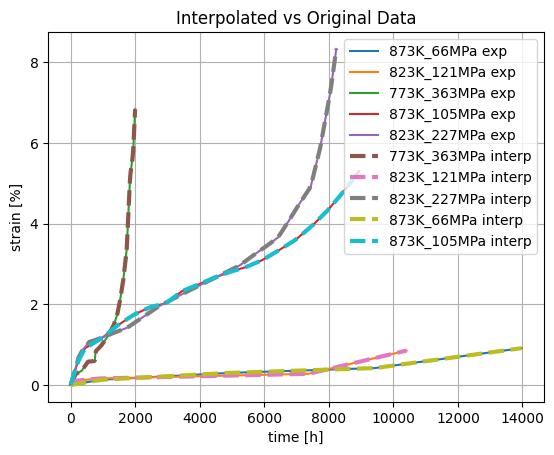

In [10]:
for stress_label in time_data:
    print(f"Initial data size for {label}:\n{time_data[stress_label].shape}")

exp_time_data = torch.zeros_like(loading, device=device)
exp_strain_data = torch.zeros_like(loading, device=device)

for label, (stress_val, temp_val) in stress_temp_map.items():
    stress_idx = (stresses == stress_val).nonzero(as_tuple=True)[0].item()
    temp_idx = (temperatures == temp_val).nonzero(as_tuple=True)[0].item()
    batch_idx = temp_idx * nrate + stress_idx

    min_time = time_data[label].min().item()
    max_time = time_data[label].max().item()

    time_values = torch.linspace(min_time, max_time, ntime, device=device)

    f_strain = interp1d(time_data[label].cpu().numpy(), strain_data[label].cpu().numpy(),kind='linear')
    interp_strain = f_strain(time_values.cpu().numpy())
    exp_strain_data[:, batch_idx, 0] = torch.tensor(interp_strain, device=device)
    exp_time_data[:, batch_idx, 0] = time_values

    print(f"Interpolated data for {label}:")
    print(f"Stress: {stress_val} MPa, Temperature: {temp_val}C")
    print(f"Batch index: {batch_idx}")
    print(f"  Time range: [{exp_time_data[:, batch_idx, 0].min():.4f}, {exp_time_data[:, batch_idx, 0].max():.4f}]")
    print(f"  Strain range: [{exp_strain_data[:, batch_idx, 0].min():.4f}, {exp_strain_data[:, batch_idx, 0].max():.4f}]")

batch_to_label = {}
for label, (stress_val, temp_val) in stress_temp_map.items():
    stress_idx = (stresses == stress_val).nonzero(as_tuple=True)[0].item()
    temp_idx = (temperatures == temp_val).nonzero(as_tuple=True)[0].item()
    batch_idx = temp_idx * nrate + stress_idx
    batch_to_label[batch_idx] = label

print("--- Interpolated Data Tensors ---")
print(f"exp time data: {exp_time_data.shape}")
print(f"exp strain data: {exp_strain_data.shape}")

plt.figure()
for stress_label in strain_data:
    plt.plot(time_data[stress_label].cpu().numpy(), strain_data[stress_label].cpu().numpy(), label=f'{stress_label} exp')
for i in range(nbatch):
    if exp_time_data[:, i, 0].abs().sum() > 0:
        batch_label = batch_to_label[i]
        plt.plot(exp_time_data[:, i, 0].cpu().numpy(), exp_strain_data[:, i, 0].cpu().numpy(), '--', linewidth=3, label=f'{batch_label} interp')
plt.xlabel('time [h]')
plt.ylabel('strain [%]')
plt.title('Interpolated vs Original Data')
plt.grid()
plt.legend()
plt.show()

In [11]:
class SolveStrain(torch.nn.Module):
    """Just integrate the model through some strain history

    Args:
        discrete_equations: the pyzag wrapped model
        nchunk (int): number of vectorized time steps
        rtol (float): relative tolerance to use for Newton's method during time integration
        atol (float): absolute tolerance to use for Newton's method during time integration
    """

    def __init__(self, discrete_equations, nchunk=1, rtol=1.0e-6, atol=1.0e-4):
        super().__init__()
        self.discrete_equations = discrete_equations
        self.nchunk = nchunk
        self.rtol = rtol
        self.atol = atol

    def forward(self, time, temperature, loading):
        """Integrate through some time/temperature/strain history and return stress
        Args:
            time (torch.tensor): batched times
            temperature (torch.tensor): batched temperatures
            loading (torch.tensor): loading conditions, which are the input strain in the first base index and then the stress (zero) in the remainder
        """
        solver = nonlinear.RecursiveNonlinearEquationSolver(
            self.discrete_equations,
            step_generator=nonlinear.StepGenerator(self.nchunk),
            predictor=nonlinear.PreviousStepsPredictor(),
            nonlinear_solver=chunktime.ChunkNewtonRaphson(rtol=self.rtol, atol=self.atol),
        )
        
        control = torch.zeros_like(loading)
        control[...,0] = 1.0

        # Setup
        forces = self.discrete_equations.forces_asm.assemble_by_variable(
            {
                "forces/t": time,
                "forces/control": control,
                "forces/T": temperature,
                "forces/fixed_values": loading
            }
        ).torch()
        state0 = torch.zeros(
            forces.shape[1:-1] + (self.discrete_equations.nstate,), device=forces.device
        )

        result = nonlinear.solve_adjoint(solver, state0, len(forces), forces)
        
        # Check if result is empty or invalid
        if result is None or len(result) == 0:
            raise RuntimeError("Solver returned empty result - integration failed")

        return result[...,0:1]

In [17]:

nchunk = 25
nmodel = neml2.load_model("creep_model.i", "implicit_rate")
nmodel.to(device = device)
print(nmodel)
model = SolveStrain(neml2.pyzag.NEML2PyzagModel(nmodel, exclude_parameters = ["E_X", "E_Y", "elasticity_nu", "R_X", "d_X", "sy_X", "mu_X", "n_X"]), nchunk=nchunk)

Name:       implicit_rate
Input:      forces/T [Scalar]
            forces/control [SR2]
            forces/fixed_values [SR2]
            forces/t [Scalar]
            old_forces/control [SR2]
            old_forces/fixed_values [SR2]
            old_forces/t [Scalar]
            old_state/internal/ep [Scalar]
            old_state/mixed_state [SR2]
            state/E_rate [SR2]
            state/S [SR2]
            state/internal/Ee_rate_rate [SR2]
            state/internal/ep [Scalar]
            state/mixed_state [SR2]
Output:     forces/S_rate_rate [SR2]
            residual/S [SR2]
            residual/internal/ep [Scalar]
            residual/mixed_state [SR2]
            state/internal/Ee_rate [SR2]
Parameters: E_X [Scalar][Double][cuda:0]
            E_Y [Scalar][Double][cuda:0]
            R_X [Scalar][Double][cuda:0]
            R_Y [Scalar][Double][cuda:0]
            d_X [Scalar][Double][cuda:0]
            d_Y [Scalar][Double][cuda:0]
            elasticity_nu [Scalar][

ValueError: Wrapped NEML2 model should have ['residual'] as (the only) output subaxes. Got ['forces', 'residual', 'state']

In [ ]:
with torch.no_grad():
    data = model(time, temperature, loading)
print(f"{data}\n{data.shape}")